# CS273A Homework 5

## Due: Wednesday Nov 19 2025 (11:59pm)
### Completed by: Vincent Tran

---
## Instructions


This homework (and subsequent ones) will involve data analysis and reporting on methods and results
using Python code. You will submit a **single PDF file** that contains everything to Gradescope. This includes any text you wish to include to describe your results, the complete code snippets of how you attempted each problem, any figures that were generated, and scans of any work on paper that you wish to include. It is important that you include enough detail that we know how you solved the problem, since otherwise we will be unable to grade it.

Your homeworks will be given to you as Jupyter notebooks containing the problem descriptions and some template code that will help you get started. You are encouraged to use these starter Jupyter notebooks to complete your assignment and to write your report. This will help you not only ensure that all of the code for the solutions is included, but also will provide an easy way to export your results to a PDF file (for example, doing *print preview* and *printing to pdf*). I recommend liberal use of Markdown cells to create headers for each problem and sub-problem, explaining your implementation/answers, and including any mathematical equations. For parts of the homework you do on paper, scan it in such that it is legible (there are a number of free Android/iOS scanning apps, if you do not have access to a scanner), and include it as an image in the Jupyter notebook.

**Double check that all of your answers are legible on Gradescope, e.g. make sure any text you have written does not get cut off.**

If you have any questions/concerns about using Jupyter notebooks, ask us on EdD. If you decide not to use Jupyter notebooks, but go with Microsoft Word or LaTeX to create your PDF file, make sure that all of the answers can be generated from the code snippets included in the document.
### Summary of Assignment: 100 total points
- Problem 1:  Decision Trees by Hand (25 points)
    - Problem 1.1:  Shannon Entropy (5 points)
    - Problem 1.2:  Information Gain (10 points)
    - Problem 1.3:  Full Tree (10 points)
- Problem 2: Decision Trees in Python (34 points)
    - Problem 2.1: Feature Statistics (8 points)
    - Problem 2.2: Initial Tree (6 points)
    - Problem 2.3: Exploring Depth Control (10 points)
    - Problem 2.4: Exploring Leaf Size (10 points)
- Problem 3: Random Forests (20 points)
    - Problem 3.1: Training Members (10 points)
    - Problem 3.2: Ensemble Prediction (10 points)
- Problem 4: VC Dimension (16 points)
    - Problem 4.1: Model A (4 points)
    - Problem 4.2: Model B (4 points)
    - Problem 4.3: Model C (4 points)
    - Problem 4.4: Model D (4 points)
- Statement of Collaboration (5 points)

Before we get started, let's import some libraries that you will make use of in this assignment. Make sure that you run the code cell below in order to import these libraries.

**Important: In the code block below, we set `seed=1234`. This is to ensure your code has reproducible results and is important for grading. Do not change this. If you are not using the provided Jupyter notebook, make sure to also set the random seed as below.**

**Important: Do not change any codes we give you below, except for those waiting for you to complete. This is to ensure your code has reproducible results and is important for grading.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import requests                                      # reading data
from io import StringIO

from sklearn.datasets import fetch_openml            # common data set access
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from sklearn.metrics import zero_one_loss as J01

import sklearn.tree as tree

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed)

---
## Problem 1: Decision Trees for Spam

In order to reduce my email load, I decide to implement a machine learning algorithm to decide whether or not I should read an email, or simply file it away instead.  To train my model, I obtain the following data set of binary-valued features about each email, including whether I know the author or not, whether the email is long or short, and whether it has any of several key words, along with my final decision about whether to read it ($y=+1$ for "read", $y=-1$ for "discard").

| X1 | X2 | X3 | X4 | X5 | y |
|----|----|----|----|----|----|
| (know author?) | (is long?)| (has 'research'?) | (has 'grade'?) | (has 'lottery'?) | (read?) |
| 0  | 0  | 1  | 1  | 0  | -1 |
| 1  | 1  | 0  | 1  | 0  | -1 |
| 0  | 1  | 1  | 1  | 1  | -1 |
| 1  | 1  | 1  | 1  | 0  | -1 |
| 0  | 1  | 0  | 0  | 0  | -1 |
| 1  | 0  | 1  | 1  | 1  |  1 |
| 0  | 0  | 1  | 0  | 0  |  1 |
| 1  | 0  | 0  | 0  | 0  |  1 |
| 1  | 0  | 1  | 1  | 0  |  1 |
| 1  | 1  | 1  | 1  | 1  | -1 |

In the case of any ties where both classes have equal probability, we will prefer to predict class $+1$.

Solve the following problems "by hand" (you can use python for logarithms, etc.)

### Problem 1.1   (5 points)

**Calculate the Shannon entropy** $H(y)$ of the binary class variable $y$, in bits.  **Hint:** Your answer should be a number between 0 and 1.

In [2]:
p_pos = 0.4
p_neg = 0.6
entropy = -(p_pos * np.log2(p_pos) + p_neg * np.log2(p_neg))
print(f'Entropy H(y): {entropy:.4f}')

Entropy H(y): 0.9710


### Problem 1.2  (5 points)

**Calculate the information gain** for each feature $x_i$.  Which feature should be split first?

In [6]:
X_hand = np.array([
    [0, 0, 1, 1, 0], # Row 1
    [1, 1, 0, 1, 0], # Row 2
    [0, 1, 1, 1, 1], # Row 3
    [1, 1, 1, 1, 0], # Row 4
    [0, 1, 0, 0, 0], # Row 5
    [1, 0, 1, 1, 1], # Row 6
    [0, 0, 1, 0, 0], # Row 7
    [1, 0, 0, 0, 0], # Row 8
    [1, 0, 1, 1, 0], # Row 9
    [1, 1, 1, 1, 1]  # Row 10
])

y_hand = np.array([-1, -1, -1, -1, -1, 1, 1, 1, 1, -1])

def entropy(y):
    if len(y) == 0: return 0
    p_pos = np.sum(y == 1) / len(y)
    p_neg = np.sum(y == -1) / len(y)
    if p_pos == 0 or p_neg == 0: return 0 # Pure node
    return -(p_pos * np.log2(p_pos) + p_neg * np.log2(p_neg))

parent_entropy = entropy(y_hand)

print(f'Parent Entropy: {parent_entropy:.4f}\n')

info_gains = []
for i in range(5):
    left_y = y_hand[X_hand[:, i] == 0]
    right_y = y_hand[X_hand[:, i] == 1]
    
    w_left = len(left_y) / len(y_hand)
    w_right = len(right_y) / len(y_hand)
    
    child_entropy = (w_left * entropy(left_y)) + (w_right * entropy(right_y))
    info_gain = parent_entropy - child_entropy

    info_gains.append(info_gain)

for i in range(5):
    print(f'Feature X{i+1}: Info Gain = {info_gains[i]:.4f}')

print(f'\nFeature {info_gains.index(max(info_gains))+1} should be split first')

Parent Entropy: 0.9710

Feature X1: Info Gain = 0.0464
Feature X2: Info Gain = 0.6100
Feature X3: Info Gain = 0.0058
Feature X4: Info Gain = 0.0913
Feature X5: Info Gain = 0.0058

Feature 2 should be split first


### Problem 1.3  (5 points)

**Draw** (or otherwise illustrate) **the complete decision tree** that will be learned from these data.

<img src="images/hw5_p1-3-3.png" alt="image" width="400"/>


<div>
    <img src="data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%20standalone%3D%22no%22%3F%3E%0A%3C%21DOCTYPE%20svg%20PUBLIC%20%22-//W3C//DTD%20SVG%201.1//EN%22%20%22http%3A//www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd%22%3E%0A%3Csvg%20stroke-miterlimit%3D%2210%22%20style%3D%22fill-rule%3Anonzero%3Bclip-rule%3Aevenodd%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3B%22%20version%3D%221.1%22%20viewBox%3D%220%200%20288%2072%22%20xml%3Aspace%3D%22preserve%22%20xmlns%3D%22http%3A//www.w3.org/2000/svg%22%20xmlns%3Axlink%3D%22http%3A//www.w3.org/1999/xlink%22%3E%0A%3Cdefs/%3E%0A%3Cg%20id%3D%22Layer-1%22%3E%0A%3Cpath%20d%3D%22M34.042%2035.8741C45.8469%2023.244%2031.1794%2022.6473%2024.2857%2024.1167C17.3921%2025.5861-0.960215%2033.2987%206.07817%2043.4256C13.1166%2053.5525%2023.0237%2056.9377%2052.2446%2053.4091C81.4656%2049.8804%2097.2436%2032.811%20122.962%2029.3111C148.681%2025.8112%20155.118%2039.4093%20155.118%2039.4093%22%20fill%3D%22none%22%20opacity%3D%221%22%20stroke%3D%22%23000000%22%20stroke-linecap%3D%22butt%22%20stroke-linejoin%3D%22round%22%20stroke-width%3D%223%22/%3E%0A%3Cpath%20d%3D%22M254.053%2040.6889C242.328%2053.1071%20256.999%2053.6247%20263.883%2052.1549C270.768%2050.685%20289.071%2043.0512%20281.969%2033.1691C274.868%2023.287%20264.94%2020.0179%20235.741%2023.6051C206.543%2027.1922%20190.872%2043.9744%20165.176%2047.5176C139.48%2051.0607%20132.957%2037.7776%20132.957%2037.7776%22%20fill%3D%22none%22%20opacity%3D%221%22%20stroke%3D%22%23000000%22%20stroke-linecap%3D%22butt%22%20stroke-linejoin%3D%22round%22%20stroke-width%3D%223%22/%3E%0A%3C/g%3E%0A%3C/svg%3E%0A" width="200"/>
</div>

## Problem 2: Decision trees in Python

In the next problem, we will use decision trees to predict a data set used for Kaggle competitions in older iterations of the course; see e.g.,
https://www.kaggle.com/c/uc-irvine-cs273a-2016

Note that I have altered the data from that competition to make the target variables +1 and -1, instead of 0/1, to better match some of the ensemble slides.

First, let's load the data:

In [7]:
url = 'https://www.ics.uci.edu/~ihler/classes/cs273/data/precip_train.txt'

with requests.get(url, verify=False) as link:
  data = np.genfromtxt(StringIO(link.text),delimiter=None)

X,Y = data[:,:-1], data[:,-1]

/home/vincent/workplace/cs273a/.venv_jupyter/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/vincent/workplace/cs273a/.venv_jupyter/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


#### Problem 2.1
Compute and print some useful statistics about the data -- the minimum, maximum, mean, and variance of each of the features.

In [8]:
feat_min = np.min(X, axis=0)
feat_max = np.max(X, axis=0)
feat_mean = np.mean(X, axis=0)
feat_var = np.var(X, axis=0)

print(f"{'Feat':<5} {'Min':<10} {'Max':<10} {'Mean':<10} {'Var':<10}")
for i in range(X.shape[1]):
    print(f"{i:<5} {feat_min[i]:<10.4f} {feat_max[i]:<10.4f} {feat_mean[i]:<10.4f} {feat_var[i]:<10.4f}")

Feat  Min        Max        Mean       Var       
0     197.0000   253.0000   241.8990   81.1988   
1     190.0000   248.0000   228.3813   89.1503   
2     214.9700   252.0200   241.9059   34.5577   
3     205.4200   252.0200   233.8254   94.5072   
4     10.0000    17130.0000 2849.0465  10505588.3006
5     0.0000     12338.0000 862.8611   3090415.2075
6     0.0000     9238.0000  163.6526   698073.3557
7     0.0000     27.4190    3.0558     7.2769    
8     1.2189     18.1070    6.3114     6.1830    
9     0.0000     11.3680    1.8939     4.1509    
10    0.0000     18.7710    4.2896     3.9446    
11    0.0000     14.7450    2.7978     1.9323    
12    1.0271     278.7100   10.4525    170.0018  
13    -999.9000  769.2000   7.6581     1528.9474 


In past assignments, we have first normalized the data (subtracting the mean and scaling each feature).  We will not do that here, however. Why is that step unnecessary for our decision tree model?

> It is not needed because decision trees split based on single-feature thresholds. Scaling a feature will result in the an identical tree structure.

#### Problem 2.2
To allow faster experimentation, select the first 10,000 data points as training data, ``Xtr, Ytr``, and the next 10,000 data points as validation, ``Xva, Yva``.  Then, learn a decision tree classifier on ``Xtr`` using the ``DecisionTreeClassifier`` class from ``scikit-learn``.  Use a large depth, say ``max_depth=100``, and the Shannon entropy impurity function in your training.  Also, use ``random_state=seed`` to ensure consistency.

Compute and print out the training error rate and validation error rate of your model.

In [9]:
Xtr, Ytr = X[:10000, :], Y[:10000]
Xva, Yva = X[10000:20000, :], Y[10000:20000]

learner = tree.DecisionTreeClassifier(max_depth=100, criterion='entropy', random_state=seed)
learner.fit(Xtr, Ytr)

tr_err = J01(Ytr, learner.predict(Xtr))
va_err = J01(Yva, learner.predict(Xva))

print(f'Training Error: {tr_err:.4f}')
print(f'Validation Error: {va_err:.4f}')

Training Error: 0.0098
Validation Error: 0.3840


#### Problem 2.3
Now try varying the ``max_depth`` parameter, , which forces the tree learning algorithm to stop after at most that many levels.  Test ``max_depth`` values in the range {1, 2, 3, ..., 16}, and plot the training and validation error rates versus ``max_depth``.
Do models with higher ``max_depth`` have higher or lower complexity?
What choice of ``max_depth`` provides the best decision tree model?

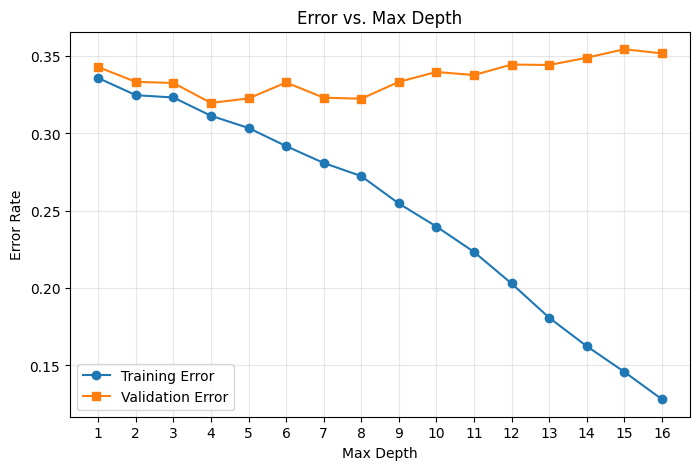

Best Max Depth: 4 with Validation Error: 0.3197


In [11]:
max_depth_range = range(1, 17)
tr_err_depth = []
va_err_depth = []

for d in max_depth_range:
    dt = tree.DecisionTreeClassifier(max_depth=d, criterion='entropy', random_state=seed)
    dt.fit(Xtr, Ytr)
    
    tr_err_depth.append(J01(Ytr, dt.predict(Xtr)))
    va_err_depth.append(J01(Yva, dt.predict(Xva)))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(max_depth_range, tr_err_depth, label='Training Error', marker='o')
plt.plot(max_depth_range, va_err_depth, label='Validation Error', marker='s')
plt.xlabel('Max Depth')
plt.ylabel('Error Rate')
plt.title('Error vs. Max Depth')
plt.legend()
plt.xticks(max_depth_range)
plt.grid(True, alpha=0.3)
plt.show()

best_depth = max_depth_range[np.argmin(va_err_depth)]
print(f'Best Max Depth: {best_depth} with Validation Error: {min(va_err_depth):.4f}')

> Models with higher `max_depth` have higher complexity. 

#### Problem 2.4
The ``min_samples_leaf`` parameter  controls the complexity of decision trees by lower bounding the amount of data required to split nodes when learning.  Fixing ``max_depth=100``, compute and plot the training and validation error rates for ``min_samples_leaf`` values in the range
``{2**0, 2**1, 2**2, ... 2**17}``.
Do models with higher ``min_samples_leaf`` have higher or lower complexity?
What choice of ``min_samples_leaf`` provides the best decision tree model?
Is this model better or worse than your depth-controlled model?

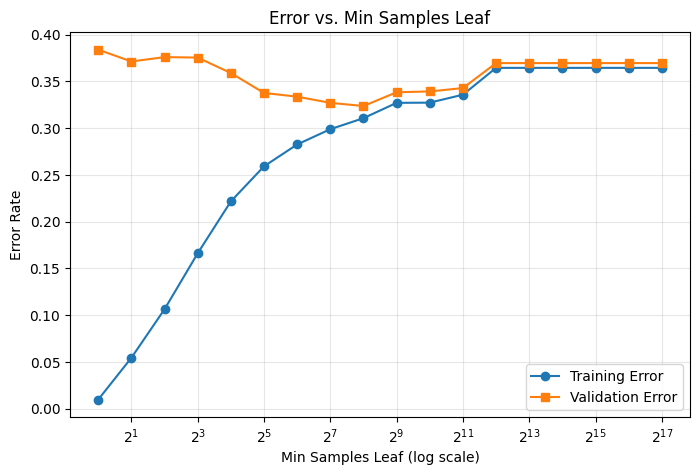

Best Min Samples Leaf: 256 with Validation Error: 0.3237


In [12]:
min_leaf_range = [2**i for i in range(18)] 
tr_err_leaf = []
va_err_leaf = []

for m in min_leaf_range:
    dt = tree.DecisionTreeClassifier(max_depth=100, min_samples_leaf=m, criterion='entropy', random_state=seed)
    dt.fit(Xtr, Ytr)
    
    tr_err_leaf.append(J01(Ytr, dt.predict(Xtr)))
    va_err_leaf.append(J01(Yva, dt.predict(Xva)))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(min_leaf_range, tr_err_leaf, label='Training Error', marker='o')
plt.plot(min_leaf_range, va_err_leaf, label='Validation Error', marker='s')
plt.xscale('log', base=2)
plt.xlabel('Min Samples Leaf (log scale)')
plt.ylabel('Error Rate')
plt.title('Error vs. Min Samples Leaf')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

best_leaf = min_leaf_range[np.argmin(va_err_leaf)]
print(f'Best Min Samples Leaf: {best_leaf} with Validation Error: {min(va_err_leaf):.4f}')

> Models with higher `min_samples_leaf` have lower complexity. This model is slightly worse than the depth control model.

<div>
    <img src="data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%20standalone%3D%22no%22%3F%3E%0A%3C%21DOCTYPE%20svg%20PUBLIC%20%22-//W3C//DTD%20SVG%201.1//EN%22%20%22http%3A//www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd%22%3E%0A%3Csvg%20stroke-miterlimit%3D%2210%22%20style%3D%22fill-rule%3Anonzero%3Bclip-rule%3Aevenodd%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3B%22%20version%3D%221.1%22%20viewBox%3D%220%200%20288%2072%22%20xml%3Aspace%3D%22preserve%22%20xmlns%3D%22http%3A//www.w3.org/2000/svg%22%20xmlns%3Axlink%3D%22http%3A//www.w3.org/1999/xlink%22%3E%0A%3Cdefs/%3E%0A%3Cg%20id%3D%22Layer-1%22%3E%0A%3Cpath%20d%3D%22M34.042%2035.8741C45.8469%2023.244%2031.1794%2022.6473%2024.2857%2024.1167C17.3921%2025.5861-0.960215%2033.2987%206.07817%2043.4256C13.1166%2053.5525%2023.0237%2056.9377%2052.2446%2053.4091C81.4656%2049.8804%2097.2436%2032.811%20122.962%2029.3111C148.681%2025.8112%20155.118%2039.4093%20155.118%2039.4093%22%20fill%3D%22none%22%20opacity%3D%221%22%20stroke%3D%22%23000000%22%20stroke-linecap%3D%22butt%22%20stroke-linejoin%3D%22round%22%20stroke-width%3D%223%22/%3E%0A%3Cpath%20d%3D%22M254.053%2040.6889C242.328%2053.1071%20256.999%2053.6247%20263.883%2052.1549C270.768%2050.685%20289.071%2043.0512%20281.969%2033.1691C274.868%2023.287%20264.94%2020.0179%20235.741%2023.6051C206.543%2027.1922%20190.872%2043.9744%20165.176%2047.5176C139.48%2051.0607%20132.957%2037.7776%20132.957%2037.7776%22%20fill%3D%22none%22%20opacity%3D%221%22%20stroke%3D%22%23000000%22%20stroke-linecap%3D%22butt%22%20stroke-linejoin%3D%22round%22%20stroke-width%3D%223%22/%3E%0A%3C/g%3E%0A%3C/svg%3E%0A" width="200"/>
</div>

## Problem 3: Random Forests

Although ``scikit`` has its own implementations of bagging estimators and random forests, here we will build a random forest model manually, for illustration.

Random Forests are bagged collections of decision trees, which select their decision nodes from randomly chosen subsets of the possible features (rather than all features).  You can implement this easily in ``DecisionTreeClassifier`` using option ``max_features=n``, where ``n`` is the number of features to select from. Since you have ~ 14 features, you might choose, say, ``n=10``; smaller values of ``n`` will make each tree more random, but may require you to have a high maximum depth to ensure you still fit the data effectively.
You'll write a for-loop to build the ensemble members, and another to compute the prediction of the ensemble.

#### Problem 3.1

Using your previous split of the data into training & validation sets,
learn a bagged ensemble of decision trees on the training data;
then in the next part, you will evaluate the validation performance of the ensemble.
(See the pseudocode from lecture slides.)
For your individual learners, use parameters that will not constrain the complexity of the resulting tree very much  (e.g., set your depth cutoff >= 15, min leaf 1-4, etc.), since the bagging will be used to control overfitting instead.

You will implement bootstrap sampling yourself (again, see pseudocode); simply generate $m'$ data indices uniformly with replacement, using ``numpy`` functions or simply ``rand`` and conversion to integers.
For your bootstrap process, draw the same number of data as in your training set after the
validation split (i.e., set $m' = m$, the number of training data).

Learn at least 50 ensemble members, as you will use them in the next part.

In [14]:
n_trees = 50
forest = []
m = Xtr.shape[0] 

learner_params = {
    'max_depth': 15,
    'min_samples_leaf': 2,
    'max_features': 10,
    'criterion': 'entropy'
}

print('Training 50 trees...')
for i in range(n_trees):
    np.random.seed(seed + i) 
    indices = np.random.choice(np.arange(m), size=m, replace=True)
    
    X_boot = Xtr[indices]
    Y_boot = Ytr[indices]
    
    dt = tree.DecisionTreeClassifier(**learner_params, random_state=seed + i)
    dt.fit(X_boot, Y_boot)
    
    forest.append(dt)

print('Training complete.')

Training 50 trees...
Training complete.


#### Problem 3.2

Plot the training and validation error of the ensemble as a function of the number of learners $B$ that you include in the ensemble, for (at least) values $B \in \{1,5,10,25,50\}$.  (Just use the first $B$ learners that you trained in part 1.)

Remember that your ensemble predicts by making a prediction for each member model, and then taking a vote among the $B$ models.  Since your target classes are +1 and -1, as in the slide pseudocode, to find the outcome of the vote you can simply check whether the average of the class predictions is positive or negative.

Computing predictions...


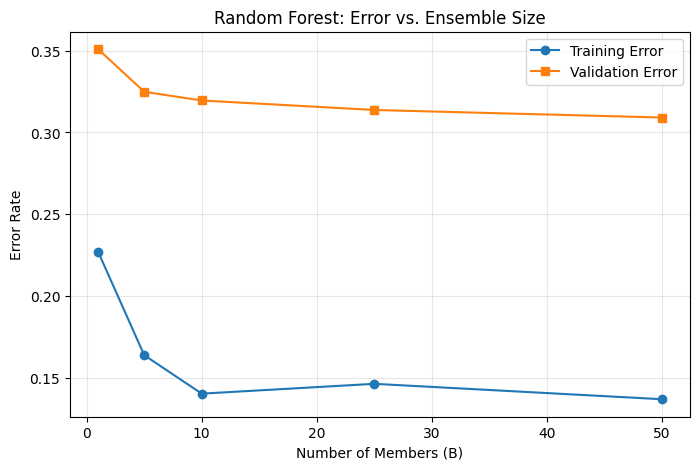

Validation Error with 1 tree: 0.3508
Validation Error with 50 trees: 0.3091


In [15]:
B_values = [1, 5, 10, 25, 50]
tr_err_rf = []
va_err_rf = []


print('Computing predictions...')
tr_preds_all = np.array([dt.predict(Xtr) for dt in forest]).T
va_preds_all = np.array([dt.predict(Xva) for dt in forest]).T

for B in B_values:
    tr_preds_subset = tr_preds_all[:, :B]
    va_preds_subset = va_preds_all[:, :B]
    
    tr_avg = np.mean(tr_preds_subset, axis=1)
    va_avg = np.mean(va_preds_subset, axis=1)
    
    tr_final = np.where(tr_avg >= 0, 1, -1)
    va_final = np.where(va_avg >= 0, 1, -1)
    
    tr_err_rf.append(J01(Ytr, tr_final))
    va_err_rf.append(J01(Yva, va_final))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(B_values, tr_err_rf, label='Training Error', marker='o')
plt.plot(B_values, va_err_rf, label='Validation Error', marker='s')
plt.xlabel('Number of Members (B)')
plt.ylabel('Error Rate')
plt.title('Random Forest: Error vs. Ensemble Size')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f'Validation Error with 1 tree: {va_err_rf[0]:.4f}')
print(f'Validation Error with 50 trees: {va_err_rf[-1]:.4f}')

<div>
    <img src="data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%20standalone%3D%22no%22%3F%3E%0A%3C%21DOCTYPE%20svg%20PUBLIC%20%22-//W3C//DTD%20SVG%201.1//EN%22%20%22http%3A//www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd%22%3E%0A%3Csvg%20stroke-miterlimit%3D%2210%22%20style%3D%22fill-rule%3Anonzero%3Bclip-rule%3Aevenodd%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3B%22%20version%3D%221.1%22%20viewBox%3D%220%200%20288%2072%22%20xml%3Aspace%3D%22preserve%22%20xmlns%3D%22http%3A//www.w3.org/2000/svg%22%20xmlns%3Axlink%3D%22http%3A//www.w3.org/1999/xlink%22%3E%0A%3Cdefs/%3E%0A%3Cg%20id%3D%22Layer-1%22%3E%0A%3Cpath%20d%3D%22M34.042%2035.8741C45.8469%2023.244%2031.1794%2022.6473%2024.2857%2024.1167C17.3921%2025.5861-0.960215%2033.2987%206.07817%2043.4256C13.1166%2053.5525%2023.0237%2056.9377%2052.2446%2053.4091C81.4656%2049.8804%2097.2436%2032.811%20122.962%2029.3111C148.681%2025.8112%20155.118%2039.4093%20155.118%2039.4093%22%20fill%3D%22none%22%20opacity%3D%221%22%20stroke%3D%22%23000000%22%20stroke-linecap%3D%22butt%22%20stroke-linejoin%3D%22round%22%20stroke-width%3D%223%22/%3E%0A%3Cpath%20d%3D%22M254.053%2040.6889C242.328%2053.1071%20256.999%2053.6247%20263.883%2052.1549C270.768%2050.685%20289.071%2043.0512%20281.969%2033.1691C274.868%2023.287%20264.94%2020.0179%20235.741%2023.6051C206.543%2027.1922%20190.872%2043.9744%20165.176%2047.5176C139.48%2051.0607%20132.957%2037.7776%20132.957%2037.7776%22%20fill%3D%22none%22%20opacity%3D%221%22%20stroke%3D%22%23000000%22%20stroke-linecap%3D%22butt%22%20stroke-linejoin%3D%22round%22%20stroke-width%3D%223%22/%3E%0A%3C/g%3E%0A%3C/svg%3E%0A" width="200"/>
</div>

## Problem 4: Shattering & VC Dimension

Consider the following four "datasets", which have two real-valued features $x_1,x_2$:

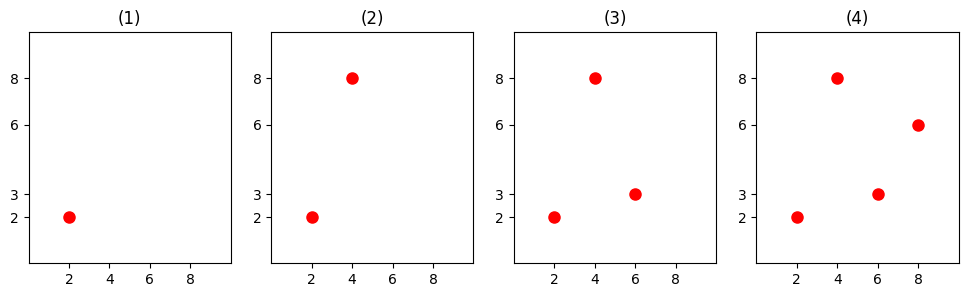

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
x = np.array([[2,2],[4,8],[6,3],[8,6]])
for i in range(4): 
    axes[i].plot(x[:i+1,0],x[:i+1,1],'ro',ms=8); axes[i].axis([0,10,0,10]); axes[i].set_title(f'({i+1})')
    axes[i].set_xticks(np.unique(x[:,0])); axes[i].set_yticks(np.unique(x[:,1])); 

(Note that no three of the four points are co-linear.)

For each of the learners listed below, answer **(a)** which of the four data sets **can be shattered** by a learner of that form?  Give a brief explanation / justification (1-2 sentences). Then use your results to **(b)** guess the VC dimension of the classifier (you do not have to give a formal proof, just your reasoning).

In each learner, the parameters $a,b,c,\ldots$ are real-valued scalars, and $T[z]$ is the sign threshold function, i.e., $T[z]=+1$ for $z\geq 0$ and $T[z] = -1$ for $z<0$.

* $T(\ a + b \ x_1 \ )$

**(a) which data sets & why?**
> Shatters datasets (1) and (2)
> * Works for 1 point
> * Works for 2 points because they have different x1 values (can place vertical line between them)
> * Fails for dataset (3) because we'd need 2 vertical lines to separate the points if x1=4 is labeled negative.

**(b) VC dimension guess?**
> VCD = 2

* $T(\ (a*b)\ x_1 + (c/a) \ x_2 \ )$

**(a) which data sets & why?**
> Shatters datasets (1) and (2)
> * Formula describes line that passes through the origin
> * Works for 1 point
> * Works for 2 points by passing line between them
> * Fails for dataset (3) because a line angled on the origin cannot accurately classify where the bottom left point is negative and other two are positive

**(b) VC dimension guess?**
> VCD = 2

* $T(\ (x_1-a)^2 + (x_2 -b)^2 - c \ )$

**(a) which data sets & why?**
> Shatters datasets (1), (2), and (3)
> * Formula describes a circle
> * Works for 3 points where you can enclose any combination of points within a circle by making it small enough.
> * Fails for dataset (4) because if diagonal points are labeled the same (e.g., bottom left & top right are positive, while top left & bottom right are negative), a circle interior cannot capture it.

**(b) VC dimension guess?**
> VCD = 3

* $T(\ a + b\,x_1 + c\,x_2 \ ) \times T(\ d + b\,x_1 + c\,x_2 \ )$
  - **Hint:** the two linear equations correspond to two parallel lines, since both have the same coefficients for $x_1$ and $x_2$.  Then, $T(z)\times T(z') = +1$ if and only if $z$ and $z'$ have the same sign.

**(a) which data sets & why?**
> Shatters all datasets
> * Works on cases that broke the previous two classifiers
> * Parallel lines can be drawn to capture any interior points and exclude any exterior points.

**(b) VC dimension guess?**
> VCD = 4

<div>
    <img src="data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%20standalone%3D%22no%22%3F%3E%0A%3C%21DOCTYPE%20svg%20PUBLIC%20%22-//W3C//DTD%20SVG%201.1//EN%22%20%22http%3A//www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd%22%3E%0A%3Csvg%20stroke-miterlimit%3D%2210%22%20style%3D%22fill-rule%3Anonzero%3Bclip-rule%3Aevenodd%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3B%22%20version%3D%221.1%22%20viewBox%3D%220%200%20288%2072%22%20xml%3Aspace%3D%22preserve%22%20xmlns%3D%22http%3A//www.w3.org/2000/svg%22%20xmlns%3Axlink%3D%22http%3A//www.w3.org/1999/xlink%22%3E%0A%3Cdefs/%3E%0A%3Cg%20id%3D%22Layer-1%22%3E%0A%3Cpath%20d%3D%22M34.042%2035.8741C45.8469%2023.244%2031.1794%2022.6473%2024.2857%2024.1167C17.3921%2025.5861-0.960215%2033.2987%206.07817%2043.4256C13.1166%2053.5525%2023.0237%2056.9377%2052.2446%2053.4091C81.4656%2049.8804%2097.2436%2032.811%20122.962%2029.3111C148.681%2025.8112%20155.118%2039.4093%20155.118%2039.4093%22%20fill%3D%22none%22%20opacity%3D%221%22%20stroke%3D%22%23000000%22%20stroke-linecap%3D%22butt%22%20stroke-linejoin%3D%22round%22%20stroke-width%3D%223%22/%3E%0A%3Cpath%20d%3D%22M254.053%2040.6889C242.328%2053.1071%20256.999%2053.6247%20263.883%2052.1549C270.768%2050.685%20289.071%2043.0512%20281.969%2033.1691C274.868%2023.287%20264.94%2020.0179%20235.741%2023.6051C206.543%2027.1922%20190.872%2043.9744%20165.176%2047.5176C139.48%2051.0607%20132.957%2037.7776%20132.957%2037.7776%22%20fill%3D%22none%22%20opacity%3D%221%22%20stroke%3D%22%23000000%22%20stroke-linecap%3D%22butt%22%20stroke-linejoin%3D%22round%22%20stroke-width%3D%223%22/%3E%0A%3C/g%3E%0A%3C/svg%3E%0A" width="200"/>
</div>

---
### Statement of Collaboration (5 points)

It is **mandatory** to include a Statement of Collaboration in each submission, with respect to the guidelines below. Include the names of everyone involved in the discussions (especially in-person ones), and what was discussed.

All students are required to follow the academic honesty guidelines posted on the course website. For
programming assignments, in particular, I encourage the students to organize (perhaps using EdD) to
discuss the task descriptions, requirements, bugs in my code, and the relevant technical content before they start
working on it. However, you should not discuss the specific solutions, and, as a guiding principle, you are not
allowed to take anything written or drawn away from these discussions (i.e. no photographs of the blackboard,
written notes, referring to EdD, etc.). Especially after you have started working on the assignment, try
to restrict the discussion to EdD as much as possible, so that there is no doubt as to the extent of your
collaboration.

> I did not collaborate with other students on this assignment. 